### Below is the code that can be used to generate Figs. 1(b-d),3,5 and 6. 

#### In the next couple cells, we define all the helper methods

In [99]:
#The Helper methods to create a CSD
import numpy as np
import matplotlib.pyplot as plt


#This method will output the CSD given the t(r) function for b.c. and defenders in time_fn_p1 and time_fn_p2 respectively. 
#Through the combine_fn parameter we can define whether to use Voronoi or Softmax formulations
def plot_multi_point_control_map(
    time_fn_p1,
    time_fn_p2,
    pos1=(0.0, 0.0),
    pos2_list=None,
    sideline_dist=sideline_distance,
    vel1=None,
    vel2_list=None,
    vel1mag=None,
    vel2mag_list=None,
    combine_fn=None,
    softmax_k=1.0,
    xlim=(-60, 60),
    ylim=(-30, 30),
    resolution=0.5,
    cmap='coolwarm',
    show_time_contours=False,
    show_vel_direc=False,
    show_people=True,
    gauss_Filter=None,
    arrow_len=1.0,
    fig_size=(9,6)
):
    """
    Plot a control map where there is one P1 and an arbitrary number of P2 points.

    Args:
      - time_fn_p1: callable f(x_rel, y_rel) -> time for P1 (coords relative to P1).
      - time_fn_p2: callable OR list of callables for P2 (each expects coords relative to that P2).
                    If a single callable is provided it will be used for all P2s.
      - pos1: (x,y) P1 position.
      - pos2_list: list of (x,y) positions for P2 team.
      - vel1: optional P1 velocity; can be an angle (radians) or a (vx,vy) tuple.
      - vel2_list: optional single velocity or list of velocities for P2 players (same format as vel1).
      - vel1mag: optional magnitude for P1 arrow (e.g. speed in m/s).
      - vel2mag_list: optional magnitudes for P2 arrows; can be:
            * None (all default length)
            * scalar (same magnitude for all P2s)
            * list/array per P2
      - combine_fn: callable combine(TT1, TT_others_stack) -> array in [0,1] giving P1 dominance.
                    If None, default softmax across [P1,P2...] is used, returning probability mass for P1.
      - softmax_k: softmax temperature when default combine is used.
      - xlim, ylim, resolution: grid extents and spacing.
      - cmap: matplotlib colormap.
      - show_time_contours: overlay time contours (P1 solid, P2 dashed).
      - arrow_len: arrow length multiplier for velocity arrows.

    Returns:
      (fig, ax, XX, YY, TT1, TT_others_stack, combined)
    """

    if pos2_list is None:
        pos2_list = []

    # grid
    xs = np.arange(xlim[0], xlim[1] + 1e-9, resolution)
    ys = np.arange(ylim[0], ylim[1] + 1e-9, resolution)
    XX, YY = np.meshgrid(xs, ys)  # shape (ny, nx)

    # TT1 (relative to pos1)
    X1 = XX - pos1[0]
    Y1 = YY - pos1[1]
    vec1 = np.vectorize(lambda xr, yr: float(time_fn_p1(xr, yr)))
    TT1 = vec1(X1, Y1).astype(float)

    # TT for each P2
    TT_others = []
    is_list_of_fns = isinstance(time_fn_p2, (list, tuple))
    for i, p2 in enumerate(pos2_list):
        X2 = XX - p2[0]
        Y2 = YY - p2[1]
        if is_list_of_fns:
            fn = time_fn_p2[i]
        else:
            fn = time_fn_p2
        vec = np.vectorize(lambda xr, yr: float(fn(xr, yr)))
        TTj = vec(X2, Y2).astype(float)
        TT_others.append(TTj)
    if TT_others:
        TT_others_stack = np.stack(TT_others, axis=0)  # shape (n2, ny, nx)
    else:
        TT_others_stack = np.zeros((0,) + TT1.shape, dtype=float)

    # default combine: softmax across P1 and P2s -> p1 = weight[P1]
    if combine_fn is None:
        def default_combine(tt1, tt_others, k=softmax_k):
            if tt_others.size == 0:
                return np.ones_like(tt1)
            all_times = np.concatenate([tt1[np.newaxis, ...], tt_others], axis=0)  # (N+1, H, W)
            # stabilize
            mn = np.min(all_times, axis=0)
            A = np.exp(-k * (all_times - mn))
            S = np.sum(A, axis=0) + 1e-12
            return A[0] / S
        combine_fn = default_combine

    combined = combine_fn(TT1, TT_others_stack)
    combined = np.asarray(combined, dtype=float)
    combined = np.nan_to_num(combined, nan=0.0, posinf=1.0, neginf=0.0)
    combined = np.clip(combined, 0.0, 1.0)

    # optional sideline mask
    if sideline_dist is not None:
        defender_mask = YY < -sideline_dist
        combined = np.where(defender_mask, 0.0, combined)

    # optional Gaussian smoothing for visualization only
    if gauss_Filter is not None:
        from scipy.ndimage import gaussian_filter
        combined_plot = gaussian_filter(combined, sigma=gauss_Filter[0], truncate=gauss_Filter[1])
    else:
        combined_plot = combined

    # plotting
    fig, ax = plt.subplots(figsize=fig_size)
    pcm = ax.pcolormesh(XX, YY, combined_plot, cmap=cmap, shading='auto', vmin=0, vmax=1)

    if show_people:
        # markers
        ax.scatter([pos1[0]], [pos1[1]], c='yellow', edgecolors='k', s=90,
                   zorder=6, label='Ball Carrier')
        if pos2_list:
            p2xs, p2ys = zip(*pos2_list)
            ax.scatter(p2xs, p2ys, c='pink', edgecolors='k', s=70,
                       zorder=6, label='Defenders')
        ax.legend(loc='upper right')

        # helper to draw a velocity arrow: vel can be angle (radians) or (vx,vy)
        def _draw_arrow(p, vel, mag=None, color='k'):
            """
            p   : (x, y) position
            vel : angle in radians OR (vx, vy) direction
            mag : scalar speed; if None, arrow_len alone sets the length
            """
            if vel is None:
                return
            try:
                # interpret vel as direction
                if isinstance(vel, (list, tuple, np.ndarray)) and len(vel) == 2:
                    vx, vy = float(vel[0]), float(vel[1])
                    norm = np.hypot(vx, vy) or 1.0
                    dirx, diry = vx / norm, vy / norm
                else:
                    angle = float(vel)
                    dirx, diry = np.cos(angle), np.sin(angle)

                # choose arrow length
                if mag is None:
                    length = arrow_len
                else:
                    length = arrow_len * float(mag)

                dx = dirx * length
                dy = diry * length

                ax.arrow(
                    p[0], p[1], dx, dy,
                    head_width=0.3, head_length=0.3,
                    fc=color, ec='k', zorder=7
                )
            except Exception:
                pass

        if show_vel_direc:
            # P1 arrow
            _draw_arrow(pos1, vel1, mag=vel1mag, color='yellow')

            # P2 arrows (vel2_list may be None, a single vel, or a list matching pos2_list)
            if pos2_list and vel2_list is not None:

                # helper to get per-defender magnitude
                def _get_mag(i):
                    if vel2mag_list is None:
                        return None
                    # single scalar for all defenders
                    if np.isscalar(vel2mag_list):
                        return float(vel2mag_list)
                    # list/array per defender
                    return float(vel2mag_list[i])

                # broadcast single velocity to all P2 players
                if (not isinstance(vel2_list, (list, tuple, np.ndarray))) or \
                   (isinstance(vel2_list, np.ndarray) and vel2_list.ndim == 1 and len(vel2_list) == 2):
                    for i, p in enumerate(pos2_list):
                        mag_i = _get_mag(i)
                        _draw_arrow(p, vel2_list, mag=mag_i, color='pink')
                else:
                    for i, (p, v) in enumerate(zip(pos2_list, vel2_list)):
                        mag_i = _get_mag(i)
                        _draw_arrow(p, v, mag=mag_i, color='pink')

    # optional time contours
    if show_time_contours:
        try:
            cs1 = ax.contour(XX, YY, TT1, levels=6,
                             colors='white', linewidths=0.6,
                             linestyles='solid', alpha=0.8)
            ax.clabel(cs1, inline=1, fontsize=8, fmt='%.1f')
            if TT_others_stack.size:
                for i in range(min(6, TT_others_stack.shape[0])):
                    cs2 = ax.contour(
                        XX, YY, TT_others_stack[i], levels=6,
                        colors='black', linewidths=0.5,
                        linestyles='dashed', alpha=0.5
                    )
                    ax.clabel(cs2, inline=1, fontsize=7, fmt='%.1f')
        except Exception:
            pass

    fig.colorbar(pcm, ax=ax)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('P1 vs P2 team control map')
    ax.set_aspect('equal')

    return fig, ax, XX, YY, TT1, TT_others_stack, combined



def voronoi_ownership(tt_ball, tt_def):
    if tt_def.size == 0:
        return np.ones_like(tt_ball)   # no defenders → full ownership

    min_def = np.min(tt_def, axis=0)
    ownership = (tt_ball < min_def).astype(float)
    return ownership

def soft_ownership(beta=1.0):
    def fn(tt_ball, tt_def):
        if tt_def.size == 0:
            return np.ones_like(tt_ball)   # no defenders → full ownership

        # Stack all players (ball first)
        all_times = np.concatenate([tt_ball[np.newaxis, ...], tt_def], axis=0)

        # Numerical stability: subtract per-pixel minimum before exponentiating
        exp_terms = np.exp(-beta * (all_times))

        denom = np.sum(exp_terms, axis=0) + 1e-12
        ownership = exp_terms[0] / denom   # ball-carrier channel
        return ownership
    return fn

In [100]:
#The Helper methods to define t(r)

#The method used to generate in the static case (Fig 1)
def euclidian_time_fn(x, y):
    """Simple time-to-reach function assuming constant velocity v in straight line."""
    return np.hypot(x, y)

#Below are the methods for the physics based model. Here vturn denotes the speed in circular motion.
#By parametrizing the problem in terms of vturn, we can optimize


#Transforming such that the motion is along the positive y axis is useful.
def transformToUpwardsMotion(x,y,vi,vt):
    #Apply a transformation matrix to make velocity vector point in the [0,1] direction
    ang=(np.pi/2 - vt)
    rot=np.array([[np.cos(ang), -np.sin(ang)],
                    [np.sin(ang), np.cos(ang)]])
    x_new, y_new = rot @ np.array([x, y])
    vi_new = vi # Assuming vi is a scalar speed, it remains unchanged by rotation
    if x_new>0: #Always CCW turn 
        x_new=-x_new
    return x_new, y_new, vi_new

#The time for the circular motion portion
def t2time(x,y,vturn,aturnmax):
    r=vturn*vturn/aturnmax
    #print(r)
    if(x**2+2*r*x+y**2<0):
        #print("Inside circle")
    #     #Descriminant negative: inside circle
    #     #need to encourage a lower vturn
        return 10*vturn+10, 10*vturn+100,0
    phi1=2*np.arctan2(-x,y+np.sqrt(x**2+2*r*x+y**2))
    phi1 = phi1 % (2 * np.pi)
    #ts=np.sqrt(x**2+2*r*x+y**2)
    #print(phi1)
    #dnew=ts*vturn
    t2= r*phi1/vturn
    newx= x - r*(1 - np.cos(phi1))
    newy= y + r*np.sin(phi1)
    dnew=np.hypot(newx,newy)
    #print(vturn,r,x,y,t2,dnew,phi1)
    return t2, dnew,phi1

#The time to traverse a straight line while accelerating with a maximum velocity
def straight_line_time(d,vi,a,vmax):
    s = np.sqrt(vi*vi + 2*a*d)
    return (s - vi)/a + np.maximum(0.0, s - vmax)**2 / (2*a*vmax)

#The full path time parametrized for the turning speed vturn
def path_time(vturn,x,y,vi,astop,ago,aturnmax,vmax):
    #print(x,y,vturn,vi)
    threshold = 0.1
    if np.abs(x)<=threshold:
        if y<0:
            #Turn and run
            t1=vi/astop
            y1= vi*t1 - 0.5*astop*t1*t1
            return vi/astop+straight_line_time(-y+y1,0,ago,vmax)
        elif y>0:
            #Go straight
            return straight_line_time(y,vi,ago,vmax)
        else:
            return 0
    if vturn>vi:
        #Accelerate
        #print("Accelerate")
        t1=(vturn-vi)/ago
        y1= vi*t1 + 0.5*ago*t1*t1
    elif vturn==vi:
        #print("Skip")
        t1=0
        y1=0
    elif vturn<vi:
        #Decelerate
        #print("Decelerate")
        t1=(vi-vturn)/astop
        y1= vi*t1 - 0.5*astop*t1*t1
    if y==y1 and x==0:
        print("HERE")
        return t1
    t2, dnew,phi1 = t2time(x, y-y1, vturn, aturnmax)
    #print(vturn,t1,t2,dnew,phi1)
    time= t1+t2 + straight_line_time(dnew,vturn,ago,vmax)
    return time
    
from scipy.optimize import minimize_scalar

#now we need to find the vturn value that minimizes the time
def optimized_physics_time(x,y,vi,vt,astop,ago,aturnmax,vmax):
    x_new, y_new, vi_new = transformToUpwardsMotion(x, y, vi, vt)
    #print(x_new, y_new, vi_new)
    #Optimize over vturn
    res1 = minimize_scalar(lambda vturn: path_time(vturn,x_new,y_new,vi_new,astop,ago,aturnmax,vmax),
                          bounds=(0, vi), method='bounded')
    res2= minimize_scalar(lambda vturn: path_time(vturn,x_new,y_new,vi_new,astop,ago,aturnmax,vmax),
                          bounds=(vi, vmax), method='bounded')
    if res1.fun<res2.fun:
        res=res1
    else:
        res=res2
    return res.x,res.fun

#handle errors
def optimized_physics_time_wrapper(x,y,vi,vt,astop,ago,aturnmax,vmax):
    #print(vi)
    try:
        return optimized_physics_time(x,y,vi,vt,astop,ago,aturnmax,vmax)[1]
    except:
        print(x,y,vi,vt)
        print("Error in optimization")
        return np.nan





#A method to generate the time-to-reach maps in Figure 3
def plot_control_map(time_fn,
                     xlim=(-60, 60),
                     ylim=(-30, 30),
                     resolution=0.5,
                     cmap='viridis',
                     normalize_method='inv',
                     clip_positive=True,
                     show_contours=True,
                     fig_size=(9,6)):
    """
    Plot a color map around (0,0) that visualizes the degree of control derived from a
    user-provided time-to-reach function.

    Args:
        time_fn: callable f(x, y) -> time (float). Interpreted as time for a player at (0,0) to reach (x,y).
        xlim, ylim: tuples giving plotting ranges (min, max).
        resolution: grid spacing in same units as x/y.
        cmap: matplotlib colormap name.
        normalize_method: how to convert time -> control. Options:
            - 'inv'   : control_raw = 1 / time
            - 'exp'   : control_raw = exp(-time)
            - 'linear': control_raw = 1 - (time - tmin) / (tmax - tmin)
            - 'none' : control_raw = time
        clip_positive: if True, negative or zero times are clipped to a small positive epsilon.
        show_contours: draw contour lines of raw time values for interpretation.

    Returns:
        fig, ax, XX, YY, TT, control  (numpy arrays & matplotlib objects)
            - TT: raw times for each grid cell
            - control: normalized control metric in [0,1] (higher => stronger control)
    """
    xs = np.arange(xlim[0], xlim[1] + 1e-9, resolution)
    ys = np.arange(ylim[0], ylim[1] + 1e-9, resolution)
    XX, YY = np.meshgrid(xs, ys)

    # Vectorize user function safely (convert returned values to float)
    vec = np.vectorize(lambda x, y: float(time_fn(x, y)))
    TT = vec(XX, YY).astype(float)

    # sanitize times
    eps = 1e-9
    if clip_positive:
        TT = np.where(TT <= 0, eps, TT)

    # convert times to a control metric in [0,1] (higher => stronger control)
    if normalize_method == 'inv':
        control_raw = 1.0 / (TT + eps)
    elif normalize_method == 'exp':
        control_raw = np.exp(-TT)
    elif normalize_method == 'linear':
        tmin = np.nanmin(TT)
        tmax = np.nanmax(TT)
        control_raw = 1.0 - (TT - tmin) / (tmax - tmin + eps)
    elif normalize_method == 'none':
        control_raw = TT
    else:
        raise ValueError('Unknown normalize_method: ' + str(normalize_method))

    # normalize to [0,1]
    cmin = np.nanmin(control_raw)
    cmax = np.nanmax(control_raw)
    control = (control_raw - cmin) / (cmax - cmin + eps)

    if normalize_method == 'none':
        control = control_raw

    # plot
    fig, ax = plt.subplots(figsize=fig_size)
    pcm = ax.pcolormesh(XX, YY, control, cmap=cmap, shading='auto')#, vmin=0, vmax=1)
    ax.scatter(0.0, 0.0, c='k', s=60, zorder=5)
    #ax.annotate('player (0,0)', xy=(0, 0), xytext=(3, 3), fontsize=9, zorder=6)

    if show_contours:
        # contours show raw times (TT) to help interpret
        try:
            cs = ax.contour(XX, YY, TT, levels=8, colors='k', linewidths=0.6, alpha=0.6)
            ax.clabel(cs, inline=1, fontsize=8, fmt='%.2f')
        except Exception:
            pass

    fig.colorbar(pcm, ax=ax, label='normalized control (0-1)')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('Control map derived from provided time-to-reach function')
    ax.set_aspect('equal')

    return fig, ax, XX, YY, TT, control

In [101]:
#The function to transform from CSD to tackle probability
def hazToProb(haz):
    return 1/(1+np.exp(-1.442885 + 4.360768 * haz))

In [102]:
#Below are the methods to calculate tackle probability along a path

#Assumes prob_field is a function prob_field(x,y) giving prob of tackle at (x,y)
#returns value of prob_field at (rx,ry)
def pk(rx,ry,XX,YY,prob_field):
    #print(rx,ry,XX,YY)
    interpolator = RegularGridInterpolator((YY[:,0], XX[0]), prob_field)
    return interpolator((ry, rx))


#Note that the formulas in the writeup are not truly accurate as the tackle probability is sensitive to the number of points in the path.
#To fix this, we can apply a logarithmic transformation to calculate the true length-independent tackle-probability. See below for a convergence test.
def calc_prob_of_tackle_along_path(path_points,XX,YY,prob_field,dist):
    #Calculate probability of tackle along a given path
    p_survive=1
    pkt=[]
    for pt in path_points:
        rx,ry=pt
        pk_val=pk(rx,ry,XX,YY,prob_field)
        lambd=-np.log(1-pk_val)
        pk_val=1-np.exp(-lambd*dist)
        pkt.append(p_survive*pk_val)
        p_survive *= (1 - pk_val)
    return p_survive, pkt

def expected_val_receiver(path_points, p_survive, pkt, move_direc="y"):
    #Calculate expected value of receiver position along path
    ev=0
    for i,pt in enumerate(path_points):
        rx,ry=pt
        if move_direc=="y":
            ev += ry * pkt[i]
        else:
            ev += rx * pkt[i]
    #print(path_points[-1][1])
    ev += (path_points[-1][1] if move_direc=="y" else path_points[-1][0]) * p_survive
    return ev
        
def getProbInfo(XX,YY,probField,pts):
    yd=[]
    pkvals=[]
    for pt in pts:
        rx,ry=pt
        yd.append(ry)
        pk_val=pk(rx,ry,XX,YY,probField)
        pkvals.append(pk_val)
    return yd,pkvals


In [103]:
#Create a path through the field
def piecewise_linear_3(xi,yi,ti,d1,t1,d2,t2,d3,n):
    #Three segment piecewise linear function decomposed into n points
    #xi,yi,ti: start point and direction (radians)
    #d1,t1: first segment length and rotation angle (radians after d1)
    #d2,t2: second segment length and rotation angle (radians after d2)
    #d3: third segment length
    #n: number of points to return in total
    points=[]
    dist_btwn_pts= (d1+d2+d3)/n
    x=0
    y=0
    angle=ti
    segments=[(d1,t1),(d2,t2),(d3,0)]
    total_d=d1+d2+d3
    points_added=0
    for seg_i,(d,turn) in enumerate(segments):
        seg_points= max(1, int(n * (d/total_d)))
        for i in range(seg_points):
            if points_added>=n:
                break
            points.append( (xi + x, yi + y) )
            x += d/seg_points * np.cos(angle)
            y += d/seg_points * np.sin(angle)
            points_added+=1
        angle += turn
    #Ensure exactly n points
    while len(points)<n:
        points.append( (xi + x, yi + y) )
    return points,dist_btwn_pts


def multiLinearPath(xi,yi,ti,turns,dists,n_points):
    #Generate a multi-linear path given initial position/direction, list of turns and distances
    points=[]
    x=0
    y=0
    angle=ti
    total_d=sum(dists)
    points_added=0
    for seg_i in range(len(turns)):
        d=dists[seg_i]
        turn=turns[seg_i]
        seg_points= max(1, int(n_points * (d/total_d)))
        for i in range(seg_points):
            if points_added>=n_points:
                break
            points.append( (xi + x, yi + y) )
            x += d/seg_points * np.cos(angle)
            y += d/seg_points * np.sin(angle)
            points_added+=1
        angle += turn
    #Ensure exactly n points
    while len(points)<n_points:
        points.append( (xi + x, yi + y) )
    return points

import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

def chaikin(pts, iterations=1):
    """
    Chaikin corner-cutting. Rounds corners; each iteration doubles points.
    pts: (N,2) array-like
    iterations: int >= 1
    """
    pts = np.asarray(pts, dtype=float)
    for _ in range(max(0, int(iterations))):
        new = []
        N = len(pts)
        if N < 2:
            return pts
        for i in range(N - 1):
            p0 = pts[i]
            p1 = pts[i + 1]
            q = 0.75 * p0 + 0.25 * p1
            r = 0.25 * p0 + 0.75 * p1
            new.append(q)
            new.append(r)
        # Optionally keep endpoints (commonly endpoints are dropped; we keep them)
        pts = np.vstack([pts[0], np.asarray(new), pts[-1]])
    return pts

def moving_average_smooth(pts, window=5):
    """
    Simple moving average applied separately to x and y.
    window: odd int >= 3
    """
    pts = np.asarray(pts, dtype=float)
    if len(pts) < 3 or window < 3:
        return pts
    if window % 2 == 0:
        window += 1
    pad = window // 2
    # pad edge values to preserve endpoints
    x = np.pad(pts[:,0], (pad,pad), mode='edge')
    y = np.pad(pts[:,1], (pad,pad), mode='edge')
    kernel = np.ones(window)/window
    xs = np.convolve(x, kernel, mode='valid')
    ys = np.convolve(y, kernel, mode='valid')
    sm = np.vstack([xs, ys]).T
    return sm

def savgol_smooth(pts, window=11, polyorder=3):
    """
    Savitzky–Golay smoothing on x and y separately.
    window must be odd and >= polyorder+2
    """
    pts = np.asarray(pts, dtype=float)
    n = len(pts)
    if n < 3:
        return pts
    if window >= n:
        window = n - (1 - n%2)  # make it largest odd < n
    if window % 2 == 0:
        window -= 1
    if window < polyorder + 2:
        window = polyorder + 2
        if window % 2 == 0:
            window += 1
    # If window still too big, fallback to moving average
    if window >= n:
        return moving_average_smooth(pts, window=max(3, n//3*2+1))
    xs = savgol_filter(pts[:,0], window_length=window, polyorder=polyorder, mode='interp')
    ys = savgol_filter(pts[:,1], window_length=window, polyorder=polyorder, mode='interp')
    return np.vstack([xs, ys]).T

def gaussian_smooth(pts, sigma=2):
    """
    Gaussian filter implemented by convolution with a Gaussian kernel.
    sigma: standard deviation in number of points
    """
    pts = np.asarray(pts, dtype=float)
    if len(pts) < 3 or sigma <= 0:
        return pts
    radius = int(max(1, np.ceil(3*sigma)))
    x = np.arange(-radius, radius+1)
    kernel = np.exp(-0.5*(x/sigma)**2)
    kernel = kernel / kernel.sum()
    pad = radius
    xs = np.pad(pts[:,0], (pad,pad), mode='edge')
    ys = np.pad(pts[:,1], (pad,pad), mode='edge')
    xs_s = np.convolve(xs, kernel, mode='valid')
    ys_s = np.convolve(ys, kernel, mode='valid')
    return np.vstack([xs_s, ys_s]).T

def smooth_sharp_turns(pts, method='chaikin', strength=1, window=None, sigma=None, **kwargs):
    """
    Unified helper to smooth sharp turns.
    - method: 'chaikin' | 'savgol' | 'moving' | 'gaussian'
    - strength: for chaikin -> iterations; for savgol/moving -> acts as window size factor
    - window: explicit window for savgol or moving
    - sigma: explicit sigma for gaussian
    Returns smoothed_pts (numpy array).
    """
    pts = np.asarray(pts, dtype=float)
    if method == 'chaikin':
        iterations = int(strength)
        iterations = max(0, iterations)
        return chaikin(pts, iterations=iterations)
    elif method == 'moving':
        if window is None:
            # scale window with strength and number of points
            window = int(max(3, min(len(pts)-1, int(strength * len(pts) / 30) | 1)))
        return moving_average_smooth(pts, window=window)
    elif method == 'savgol':
        if window is None:
            window = int(max(3, min(len(pts)-1, int(strength * len(pts) / 20) | 1)))
        # polyorder default 3
        return savgol_smooth(pts, window=window, polyorder=kwargs.get('polyorder', 3))
    elif method == 'gaussian':
        if sigma is None:
            sigma = max(0.5, float(strength))
        return gaussian_smooth(pts, sigma=sigma)
    else:
        raise ValueError("Unknown method: " + str(method))

def path_step_distance(pts):
    """
    Return mean step distance and full array of step lengths for a path.
    """
    arr = np.asarray(pts, dtype=float)
    if len(arr) < 2:
        return 0.0, np.array([])
    dx = np.diff(arr[:,0])
    dy = np.diff(arr[:,1])
    d = np.hypot(dx, dy)
    return float(d.mean()), d

def evenlyDistributePts(pts,n):
    #Given a set of path points, redistribute to n evenly spaced points
    arr = np.asarray(pts, dtype=float)
    if len(arr) < 2:
        return pts
    #Calculate cumulative distance along path
    dx = np.diff(arr[:,0])
    dy = np.diff(arr[:,1])
    d = np.hypot(dx, dy)
    cumd = np.concatenate(([0], np.cumsum(d)))
    total_d = cumd[-1]
    if total_d == 0:
        return [tuple(arr[0])] * n
    #New evenly spaced distances
    new_dists = np.linspace(0, total_d, n)
    new_pts = []
    j = 0
    for nd in new_dists:
        while j < len(cumd) - 1 and cumd[j+1] < nd:
            j += 1
        if j == len(cumd) - 1:
            new_pts.append((arr[-1,0], arr[-1,1]))
        else:
            t = (nd - cumd[j]) / (cumd[j+1] - cumd[j]) if cumd[j+1] != cumd[j] else 0
            x_new = arr[j,0] + t * (arr[j+1,0] - arr[j,0])
            y_new = arr[j,1] + t * (arr[j+1,1] - arr[j,1])
            new_pts.append((x_new, y_new))
    return new_pts



In [104]:
#Below is code to calculate the optimal path for the receiver to maxmize the expected YAC value. These functions are provided, but not used.
#Some penalties need to be added to discourage unnecssary turns and to encourage complete paths.


def getPathExpectedVal(pts,XX,YY,probField,locald):
    #Given a set of path points, calculate expected value and return negative (for minimization)
    p_survive, pkt=calc_prob_of_tackle_along_path(pts, XX, YY, probField, locald)
    exp_val=expected_val_receiver(pts, p_survive, pkt, move_direc="y")
    return -exp_val

def checkPathValidity(pts,xmax,ymax):
    BIG=1e6
    for pt in pts:
        rx,ry=pt
        if rx<-xmax or rx>xmax or ry<0 or ry>ymax:
            return False
    return True
def boundary_penalty(pts, xmax, ymax):
    """Quadratic penalty for going outside the box [-xmax, xmax] × [0, ymax]."""
    pen = 0.0
    for x, y in pts:
        if x < -xmax:
            pen += (-xmax - x)**2
        elif x > xmax:
            pen += (x - xmax)**2

        if y < 0:
            pen += (0 - y)**2
        elif y > ymax:
            pen += (y - ymax)**2
    return pen
def end_penalty(pts, ymax):
    """Penalty if the path does not reach the top y = ymax."""
    y_end = pts[-1][1]
    # Only penalize if we fall short of the top
    if y_end < ymax:
        return (ymax - y_end)**2
    else:
        return 0.0
def turn_penalty(params, lam_turn=0.1):
    """Penalty for sharp turns in the path."""
    t1 = params[1]
    t2 = params[3]
    pen = lam_turn * (t1**2 + t2**2)
    return pen
def length_penalty(params, lam_length=1):
    """Penalty for long paths."""
    d1 = params[0]
    d2 = params[2]
    d3 = params[4]
    pen = lam_length * (d1 + d2 + d3)
    return pen
def getPathFromParams(params,xi,yi,ti,n_points):
    d1=params[0]
    t1=params[1]
    d2=params[2]
    t2=params[3]
    d3=params[4]
    pts,locald= piecewise_linear_3(xi,yi,ti,d1,t1,d2,t2,d3,n_points)
    return pts,locald

def pathObjective(params, xi, yi, ti, n_points,XX,YY, probField, xmax, ymax,
                  lam_boundary=1e3):
    #Given path parameters, return objective value (negative expected value + penalties)
    #Unnormalize params
    #params = denormalizeParamsBetweenBounds(params)
    pts, locald = getPathFromParams(params, xi, yi, ti, n_points)
    if not checkPathValidity(pts, xmax, ymax):
        pen = boundary_penalty(pts, xmax, ymax)
        return lam_boundary*pen
    base_cost = getPathExpectedVal(pts, XX,YY,probField, locald)   # negative EV
    pen_end = end_penalty(pts, ymax)
    pen_turn = turn_penalty(params)
    pen_length = length_penalty(params)

    # Total objective: minimize (negative EV + penalty)
    return base_cost+pen_end+pen_turn+pen_length


def findIdealPath(XX,YY,probField):
    #Optimize path to maximize expected value of receiver position
    from scipy.optimize import minimize

    #Ics
    xi=0
    yi=0
    ti=np.pi/2

    ymax=10
    xmax=5    
    
    
    #Initial guess: straight line path
    n_points=200
    #Optimize for d1, t1, d2, t2, d3
    initial_params=[2,-np.pi/2,1,np.pi/2,1]
    bounds=[(0,12),(-np.pi/2,np.pi/2),(0,12),(-np.pi/2,np.pi/2),(0,12)]

    pts0, locald0 = getPathFromParams(initial_params, xi, yi, ti, n_points)
    print("Initial path valid?", checkPathValidity(pts0, xmax, ymax))
    print("Initial expected value:", pathObjective(initial_params, xi, yi, ti, n_points, XX,YY,probField, xmax, ymax))
    res = minimize(pathObjective, initial_params,
                   args=(xi,yi,ti,n_points,XX,YY,probField,xmax,ymax),
                   bounds=bounds,
                   method='L-BFGS-B',
                   options={'disp': True, 'maxiter': 100})
    print("Optimized path parameters:", res.x)
    pts_opt,locald_opt= getPathFromParams(res.x,xi,yi,ti,n_points)
    e_opt=getPathExpectedVal(pts_opt,XX,YY,probField,locald_opt)
    print("Optimized expected value:", e_opt)
    return pts_opt

In [105]:
#Used for Theoretical Figs
player_1_pos = (0, 0)
player_1_speed = 4  # units per second
player_1_dir = np.pi / 2  
defenders_pos = [(-2, 2.5), (2, 2.5)]
defenders_speed = [3+2, 3+2]
defenders_dir = [7*np.pi / 4, 5*np.pi / 4]
sideline_distance=25


#In-game data from Fig 1a
#At time of throw
# example: elementwise tuple subtraction

# player_1_pos = (-1*(91.41-91),12.83-14.32)
# player_1_speed = 4.404  # units per second
# player_1_dir =-(np.pi-3.218)
# defenders_pos = [(-(95.28-91), -(8.61-14.32)), (-(93.61-91), -(18.39-14.32))]
# defenders_speed = [1.26, 2.16]
# defenders_dir = [-(np.pi-2.98), -(np.pi-3.34)]
# sideline_distance=14.32



#At catch time
# player_1_pos = ((91.41-91.41),12.83-12.83)
# player_1_speed = 1.303  # units per second
# player_1_dir =-(np.pi-(-1.647))
# defenders_pos = [(-(93.17-91.41), -(9.82-12.83)), (-(93.25-91.41), -(15.56-12.83))]
# defenders_speed = [4.404, 4.81]
# defenders_dir = [-(np.pi-(2.452)),-(np.pi-(-1.932))]
# sideline_distance=14.32


#Theoretical Aggressive/Conservative Strategy
# player_1_pos = ((91.41-91.41),12.83-12.83)
# player_1_speed = 1.303  # units per second
# player_1_dir =-(np.pi-(-1.647))
# defenders_pos = [(-(93.17-91.41), -(9.82-12.83)), (-(95.3-91.41), -(15.56-12.83))]
# defenders_speed = [4.837, 2.81]
# defenders_dir = [-(np.pi-(2.197)),-(np.pi-(-2.313))]
# sideline_distance=14.32


#((91.41, 12.83, 1.3038404810405415, -1.6475682180647133), ((93.17, 9.82), (93.25, 15.56)), (4.404543109109081, 4.810405388322294), (2.452668265374935, -1.9320000822885808))


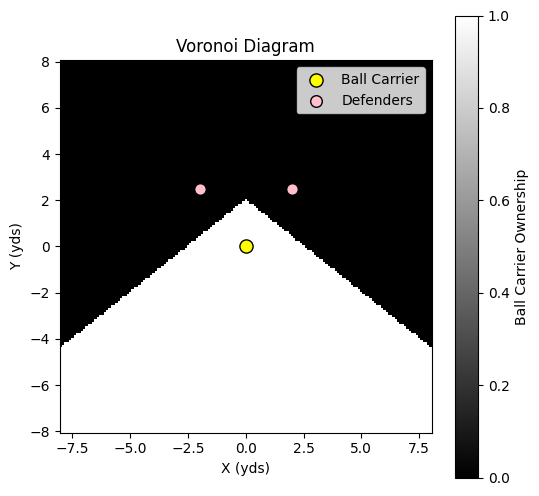

In [106]:

pos1 = player_1_pos
v1=player_1_speed
v1t=player_1_dir
pos2_list = defenders_pos
v2_list=defenders_speed
v2t_list=defenders_pos
from functools import partial

# P1 function
time_fn_p1 = partial(euclidian_time_fn)

# Make one function per P2 player (bind each player's v and vt)
time_fn_p2_list = [
    partial(euclidian_time_fn)
    for v, vt in zip(v2_list, v2t_list)
]

# Call the multi-point plot with the list of fns
fig, ax, XX, YY, TT1, TT_others, combined = plot_multi_point_control_map(
    time_fn_p1,
    time_fn_p2_list,
    pos1=pos1,
    pos2_list=pos2_list,
    sideline_dist=sideline_distance,
    vel1=v1t,
    vel2_list=v2t_list,
    combine_fn=voronoi_ownership,
    xlim=(-8, 8), #CHANGE THESE BOUNDS TO INCREASE VIEW
    ylim=(-8, 8),
    resolution=0.1,
    cmap='grey',
    show_time_contours=False,
    show_vel_direc=False,
    show_people=True,
    arrow_len=1.0,
    fig_size=(6,6)
)
plt.title("Voronoi Diagram")
plt.xlabel("X (yds)")
plt.ylabel("Y (yds)")
cbar_ax = fig.axes[-1]
cbar_ax.set_ylabel("Ball Carrier Ownership")

#ax.get_figure().axes[-1].set_visible(False)
plt.show()

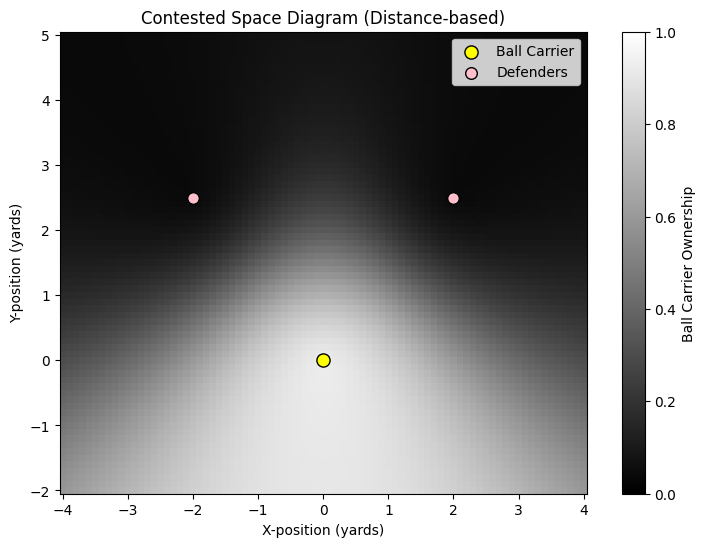

In [107]:
fig, ax, XX, YY, TT1, TT_others, combined = plot_multi_point_control_map(
    time_fn_p1,
    time_fn_p2_list,
    pos1=pos1,
    pos2_list=pos2_list,
    sideline_dist=sideline_distance,
    vel1=v1t,
    vel2_list=v2t_list,
    combine_fn=soft_ownership(beta=1),
    xlim=(-4, 4),
    ylim=(-2, 5),
    resolution=0.1,
    cmap='grey',
    show_time_contours=False,
    gauss_Filter=None,
    show_vel_direc=False,
    show_people=True,
    arrow_len=1.0,
    
)
plt.title("Contested Space Diagram (Distance-based)")
plt.xlabel("X-position (yards)")
plt.ylabel("Y-position (yards)")
cbar_ax = fig.axes[-1]
cbar_ax.set_ylabel("Ball Carrier Ownership")


# Ownership boundary (e.g., 0.5 contour)
if(False):
    cs3 = ax.contour(XX, YY, combined, levels=[0.3], colors=['white'], linewidths=1.2)

plt.show()

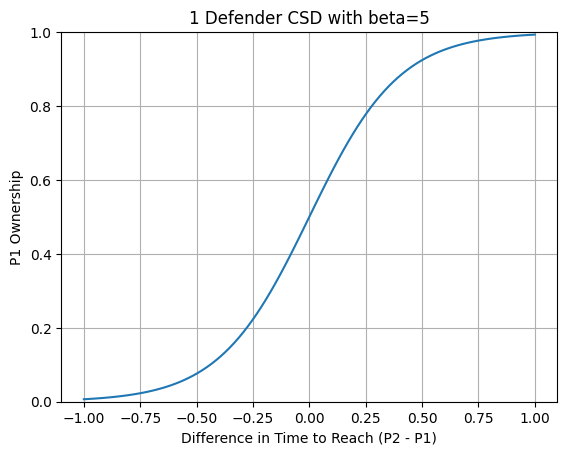

In [108]:
dt=np.linspace(-1,1,100)
g=1/(1+np.exp(-5*dt))
plt.plot(dt,g)
plt.title("1 Defender CSD with beta=5")
plt.xlabel("Difference in Time to Reach (P2 - P1)")
plt.ylabel("P1 Ownership")
plt.grid()
plt.ylim(0,1)
#plt.xlim(-1,1)
plt.show()

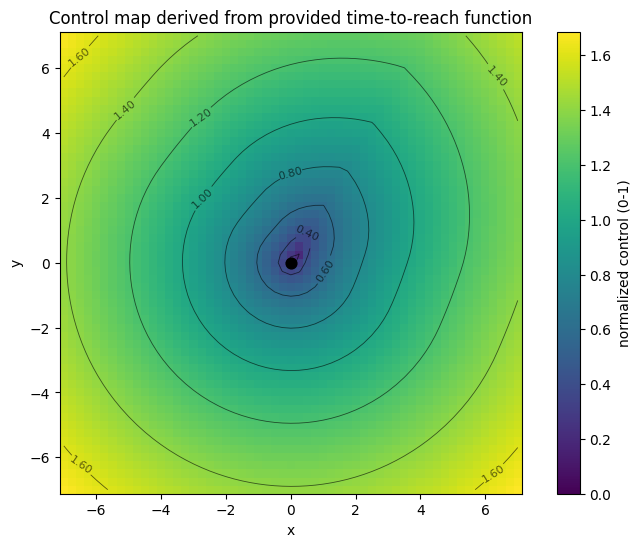

In [109]:
fig, ax, XX_prob, YY_prob, TT, control = plot_control_map(lambda x,y: optimized_physics_time(x,y,vi=1,vt=np.pi/3,astop=12,ago=8,aturnmax=7,vmax=10.5)[1],
                                               xlim=(-7,7), ylim=(-7,7),
                                               resolution=0.25, clip_positive=False, cmap='viridis',
                                               normalize_method='none',show_contours=True)
plt.show()


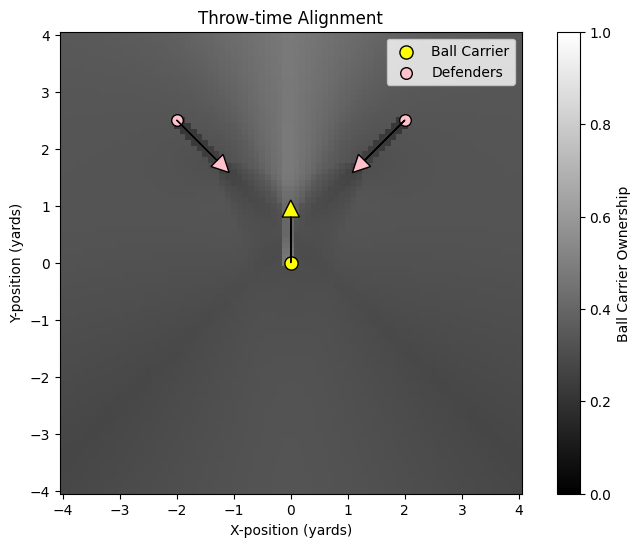

In [115]:
pos1 = player_1_pos
v1=player_1_speed
v1t=player_1_dir
pos2_list = defenders_pos
v2_list=defenders_speed
v2t_list=defenders_dir

# P1 function
time_fn_p1 = partial(optimized_physics_time_wrapper,vi=v1,vt=v1t,astop=12,ago=8,aturnmax=7,vmax=10.5)

# Make one function per P2 player (bind each player's v and vt)
time_fn_p2_list = [
    partial(optimized_physics_time_wrapper,vi=v,vt=vt,astop=12,ago=8,aturnmax=7,vmax=10.5)
    for v, vt in zip(v2_list, v2t_list)
]

# Call the multi-point plot with the list of fns
fig, ax, XX, YY, TT1, TT_others, combined = plot_multi_point_control_map(
    time_fn_p1,
    time_fn_p2_list,
    pos1=pos1,
    pos2_list=pos2_list,
    sideline_dist=sideline_distance,
    vel1=v1t,
    vel2_list=v2t_list,
    vel1mag=v1,
    vel2mag_list=v2_list,
    combine_fn=soft_ownership(beta=1),
    xlim=(-4, 4),
    ylim=(-4, 4),
    resolution=0.1,
    cmap='grey',
    show_time_contours=False,
    show_vel_direc=True,
    show_people=True,
    gauss_Filter=None,
    arrow_len=0.2
)
#plt.title("Contested Space Diagram (Physics-based)")
plt.title("Throw-time Alignment")
plt.xlabel("X-position (yards)")
plt.ylabel("Y-position (yards)")
fig.axes[-1].set_ylabel("Ball Carrier Ownership")
plt.show()

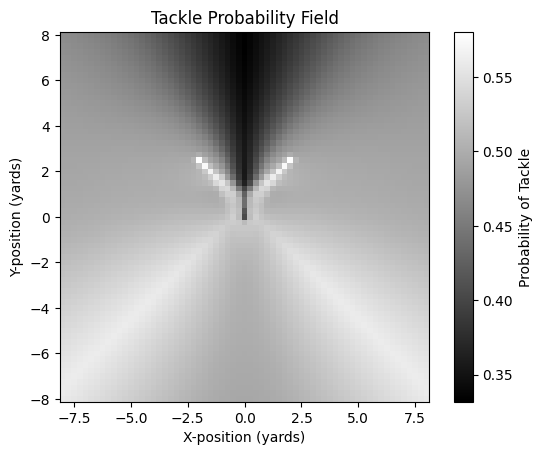

In [111]:
probField= hazToProb(combined)
from scipy.ndimage import gaussian_filter
probField = gaussian_filter(probField, sigma=0.5,truncate=2)
plt.figure()
plt.pcolormesh(XX, YY, probField, cmap='grey', shading='auto')
plt.colorbar(label='Probability of Tackle')
plt.xlabel('x')
plt.ylabel('y')
plt.title("Tackle Probability Field")
plt.xlabel("X-position (yards)")
plt.ylabel("Y-position (yards)")
plt.gca().set_aspect('equal')
plt.show()

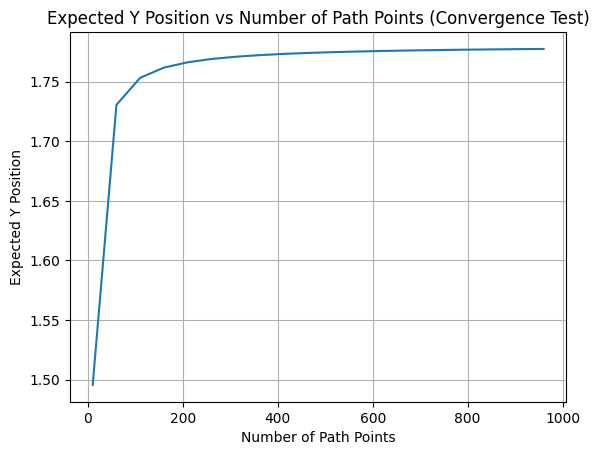

In [112]:
from scipy.interpolate import RegularGridInterpolator

n_arr=np.arange(10,1000,50)
exp_vals=[]
for n in n_arr:
    
    pts,locald= piecewise_linear_3(0,0,np.pi/2+0.05,3,0.5,3,0.5,0,n)
    p_survive, pkt=calc_prob_of_tackle_along_path(pts, XX,YY,probField, locald)
    exp_val=expected_val_receiver(pts, p_survive, pkt, move_direc="y")
    exp_vals.append(exp_val)
plt.figure()
plt.plot(n_arr, exp_vals)
plt.title('Expected Y Position vs Number of Path Points (Convergence Test)')
plt.xlabel('Number of Path Points')
plt.ylabel('Expected Y Position')
plt.grid()
plt.show()

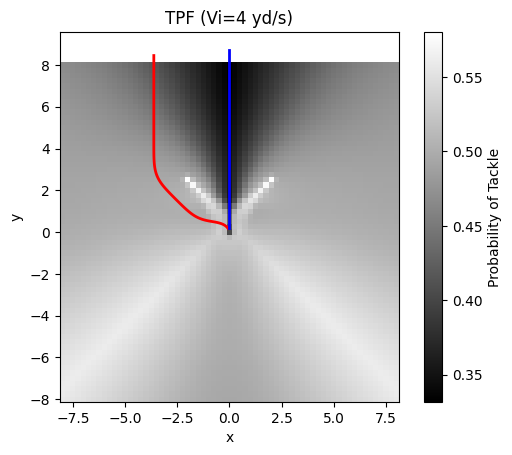

ValueError: One of the requested xi is out of bounds in dimension 0

In [113]:
pts1 = multiLinearPath(0,0,np.pi/2,[np.pi/2,-np.pi/4,-np.pi/4,-np.pi/4],[0.5,1.5,3,6],100)
pts1 = evenlyDistributePts(smooth_sharp_turns(pts1, method='gaussian', strength=5), 100)
pts2 = evenlyDistributePts(smooth_sharp_turns(multiLinearPath(0,0,np.pi/2,[np.pi/2],[9],100), method='gaussian', strength=5), 100)

plt.figure()
plt.pcolormesh(XX, YY, probField, cmap='grey', shading='auto')
plt.colorbar(label='Probability of Tackle')
plt.xlabel('x')
plt.ylabel('y')
plt.title('TPF (Vi=4 yd/s)')
plt.gca().set_aspect('equal')

#Sample paths
xs1,ys1=zip(*pts1)
plt.plot(xs1,ys1,c='red',linewidth=2,label='Gap Route')
xs2,ys2=zip(*pts2)
plt.plot(xs2,ys2,c='blue',linewidth=2,label='Around Route')
plt.show()

yd1,p1=getProbInfo(XX,YY,probField,pts1)
plt.plot(yd1,p1,label='Around Path',color='red')

yd2,p2=getProbInfo(XX,YY,probField,pts2)

locald1= path_step_distance(pts1)[0]
locald2= path_step_distance(pts2)[0]
exp1=-1*getPathExpectedVal(pts1,XX,YY, probField, locald1)
exp2=-1*getPathExpectedVal(pts2,XX,YY, probField, locald2)

plt.vlines(exp1, ymin=0, ymax=1, color='red', linestyle='dashed', label='Exp YAC Around Path: {:.2f}'.format(exp1))
plt.vlines(exp2, ymin=0, ymax=1, color='blue', linestyle='dashed', label='Exp YAC Gap Path: {:.2f}'.format(exp2))

plt.plot(yd2,p2,label='Gap Path',color='blue')
plt.ylabel('Probability of Tackle')
plt.xlabel('Y Position Along Route')
plt.title('Tackle Probability Along Sample Routes (Vi=4 yd/s)')
plt.legend()
plt.ylim(0.05,0.7)
plt.xlim(0,5)
plt.show()

